# Simulating KiCad schematics with Spice

This project is a small set of Python modules to simulate KiCad schematics using a Spice simulator, for example Ngspice or Xyce.

To use these models, design a schematic as usual in KiCad using KiCad's normal R, C, L components and components from the Pspice library.  Load the schematic and use the Spice engine to do AC, DC, transient or noise simulations and get the results back as numpy arrays.  You can then perform calculations or plot the arrays using any tool you'd like.  In this demo I'm using matplotlib.

There's one more good reason to use matplotlib: one of these modules can render the KiCad schematic to a matplotlib plot which is rather nice if you want to show the schematic in a Jupyter notebook like this.

### Basic stuff

In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# The spice and kicad modules are located above us
import sys
sys.path.append('../..')

### Load a kicad schematic

In [2]:
from kicad import schema
fn = 'butterworth.sch'
sch = schema.Sch(fn)

### Render the kicad schematic in a matplotlib plot
Yes, using matplotlib as a drawing backend is a bit ugly, but it works and it means that we can display it using every backend supported by matplotlib, such as in a Jupyter notebook.  And having the schematic available directly in the notebook when working with it is rather nice.

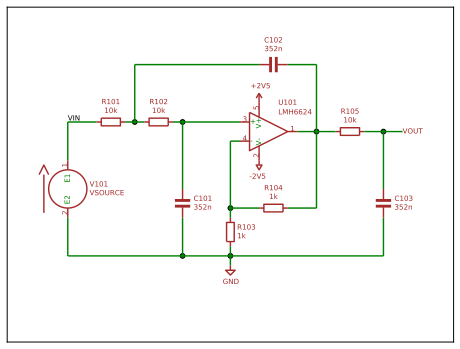

In [3]:
from kicad import matplotlib_renderer
fig, ax = plt.subplots(figsize = (8, 6))
# Add a bit of margin since matplotlib chops off the text otherwise
ax.set_xmargin(0.1)
ax.set_ymargin(0.1)
matplotlib_renderer.render_to_ax(ax, sch)
plt.show()

... or save the figure in any file format supported by matplotlib.

In [4]:
# Make the plot fill the whole image
fig.subplots_adjust(left = 0, right = 1.0, top = 1.0, bottom = 0.0)
fig.savefig('butterworth.png')
fig.savefig('butterworth.svg')
fig.savefig('butterworth.pdf')

You can check out the resulting [PNG](./butterworth.png), [SVG](./butterworth.svg), and [PDF](./butterworth.pdf) files here.

Also note that the "plt.show()" command at the end really isn't needed in a Jupyter notebook, but if you want to try this directly in Python you will need it.

The schematic contains R and C symbols from the Device library and the component values are extracted from the normal value field.

The power symbols have names of the form "+iVf" or "-iVf" where i is the integer part and f is the fractional part of the voltage; e.g. "-2V5" will add a -2.5V DC voltage supply between the symbol and ground.

Symbols from the Spice library ought to work, but I have only tested the voltage and current sources.

It should be possible to annotate any other symbols with Spice models and make them work too.  For an example on how to do this, look at how the [OP-amp in the butterworth schematic has been set up](./butterworth-opamp.png).

### Convert the kicad schematic to a spice circuit

In [5]:
from kicad import spice_converter
circuit = spice_converter.sch_to_circuit(sch)

### Set up the Spice simulator

In [6]:
from spice import ngspice, xyce, ltspice
sim = ngspice.Simulator()
# sim = xyce.Simulator()
# sim = ltspice.Simulator()

# Print the Spice circuit
print(sim.circuit_to_spice(circuit).strip())

#include "./LMH6624.MOD"
VPWR0102 11 0 2.5
VPWR0101 10 0 0
R101 4 VIN 10.0k
XU101 3 2 11 12 6 LMH6624
V101 VIN 10 dc 0 ac 1 pulse(0 1 1m 1m 1m 17m 50m)
C102 6 4 352.0n
VPWR0103 12 0 -2.5
C101 3 10 352.0n
R102 4 3 10.0k
C103 VOUT 10 352.0n
R104 2 6 1.0k
R103 2 10 1.0k
R105 6 VOUT 10.0k


### Perform a DC simulation and plot it

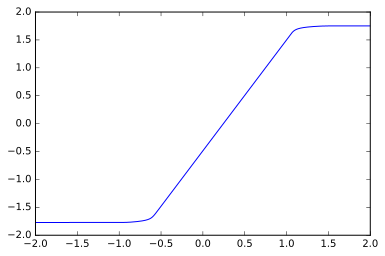

In [7]:
# Import some convenient SI prefixes and a decibel converter
from spice.unit import G, M, k, m, u, n, p, dBa

# Run the DC simulation
dc_data = sim.dc(circuit, 'V101', -2, 2, 1 * m)

# Plot the results
plt.plot(dc_data['SWEEP'], dc_data['V(VOUT)']);

# Show the plot
plt.show()

We can see that vout is limited by the supply voltage to the OP-amp.

### Perform multiple AC simulations varying the capacitor values

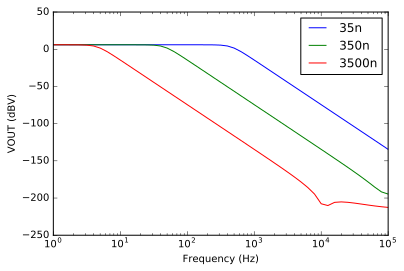

In [8]:
# The capacitor names and values we want to use
cap_refs = [ 'C101', 'C102', 'C103' ]
cap_values = [ 35 * n, 350 * n, 3500 * n ]

# Run the simulations and save the results in ac_data
ac_data = []
for v in cap_values:
    for ref in cap_refs:
        circuit[ref].value = v
    ac_data.append((v, sim.ac(circuit, 'dec', 10, 1, 100 * k)))
    
# Show all the results from ac_data in one plot
for v, data in ac_data:
    # The Y values are converted to dB
    plt.plot(data['SWEEP'].real, dBa(data['V(VOUT)']), label = str(v))   

# Change the X axis scale to logarithmic
plt.xscale('log')

# Add a legend and labels for the axes
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("VOUT (dBV)")

# Show the plot
plt.show()

### Do transient simulations

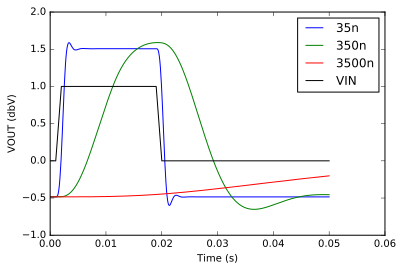

In [9]:
# Run simulations with all the values
tran_data = []
for v in cap_values:
    for ref in cap_refs:
        circuit[ref].value = v
    tran_data.append((v, sim.tran(circuit, 100 * u, 50 * m)))

# Plot the results
for v, data in tran_data:
    plt.plot(data['TIME'].real, data['V(VOUT)'], label = str(v))

# Plot vin for the last simulation so that we can see the stimuli
plt.plot(data['TIME'].real, data['V(VIN)'], label = "VIN", color = 'black')

# Add a legend and labels for the axes
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("VOUT (dbV)");

# Show the plot
plt.show()

### Pretty figures
Matplotlib can have multiple subplots in one figure.  Which can make for some rather nice "datasheet"-like figures.


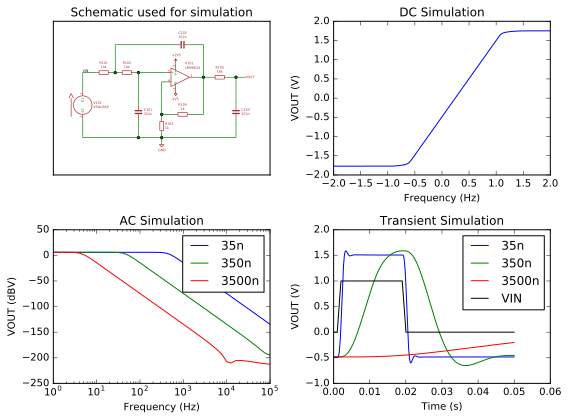

In [10]:
fig = plt.figure(figsize = (8, 6))

ax = fig.add_subplot(2, 2, 1)
ax.set_title("Schematic used for simulation")
ax.set_xmargin(0.1)
ax.set_ymargin(0.1)
matplotlib_renderer.render_to_ax(ax, sch)

ax = fig.add_subplot(2, 2, 2)
ax.set_title("DC Simulation")
ax.plot(dc_data['SWEEP'], dc_data['V(VOUT)'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("VOUT (V)")

ax = fig.add_subplot(2, 2, 3)
for v, data in ac_data:
    ax.plot(data['SWEEP'].real, dBa(data['V(VOUT)']), label = str(v))   
ax.set_xscale('log')
ax.set_title("AC Simulation")
ax.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("VOUT (dBV)")

ax = fig.add_subplot(2, 2, 4)
for v, data in tran_data:
    ax.plot(data['TIME'].real, data['V(VOUT)'], label = str(v))
ax.plot(data['TIME'].real, data['V(VIN)'], label = "VIN", color = 'black')
ax.set_title("Transient Simulation")
ax.legend()
plt.xlabel("Time (s)")
plt.ylabel("VOUT (V)")

# Stop the figures from overlapping
fig.tight_layout()

# Show the plot
plt.show()